The RT60 is 82 ms
(6, 201674)
(257, 787, 6)


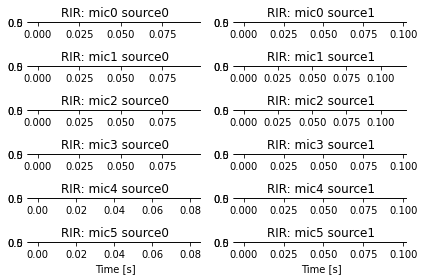

In [16]:
import numpy as np
import librosa
from scipy.fftpack import fft
import matplotlib.pyplot as plt
from DistantSpeech.transform.transform import Transform
from DistantSpeech.beamformer.utils import pmesh, mesh, load_wav, save_audio, load_pcm, visual
from DistantSpeech.beamformer.utils import load_audio as audioread
from DistantSpeech.beamformer.utils import save_audio as audiowrite
from DistantSpeech.beamformer.MicArray import MicArray, ArraySim
from DistantSpeech.beamformer.beamformer import beamformer
from DistantSpeech.beamformer.MicArray import MicArray, compute_tau
from DistantSpeech.noise_estimation.mcspp import McSpp
wavpath = '/home/wangwei/work/Beamforming-for-speech-enhancement-master/sample_data'
array_data, _ = load_wav(wavpath)

mic_angle_vector = [0,60,120,180,240,300]
sampling_frequency = 16000
fft_length = 512
fft_shift = 256
mic_diameter = 0.1
sound_speed = 343
look_direction = 30

signal = audioread("/home/wangwei/work/DistantSpeech/samples/audio_samples/cleanspeech_aishell3_2.wav")
noise = audioread("/home/wangwei/work/DistantSpeech/samples/noise/office1.wav")
fs = 16000
M = 6
mic_array = MicArray(arrayType="circular", r=mic_diameter/2, M=M, n_fft=fft_length)
mic_array_sim = mic_array.array_sim
# print(mic_array_sim.R)
array_data, premix = mic_array_sim.generate_audio(signal, interference=noise, source_angle=look_direction, interf_angle=270, sir=10, snr=30)
# audiowrite('mix.wav', np.transpose(array_data))
# audiowrite('signal.wav', np.transpose(premix[0, :, :]))
# audiowrite('interf.wav', np.transpose(premix[1, :, :]))
print(array_data.shape)
M = array_data.shape[0]
transform = Transform(n_fft=512, hop_length=256, channel=M)
D = transform.stft(np.transpose(array_data))
half_bin = D.shape[0]
frame_num = D.shape[1]
print(D.shape)

[1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
(257, 6, 6)
[[-1.26242770e-04]
 [-1.26242770e-04]
 [-2.02300114e-20]
 [ 1.26242770e-04]
 [ 1.26242770e-04]
 [-3.03450171e-20]]


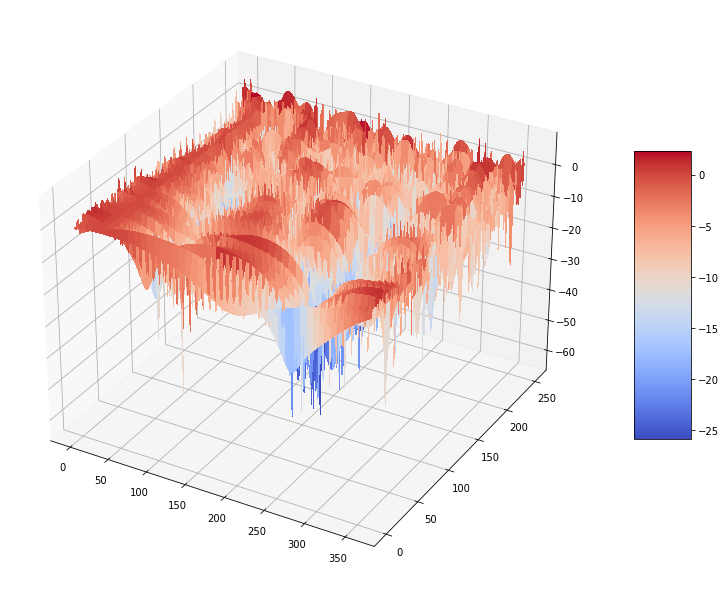

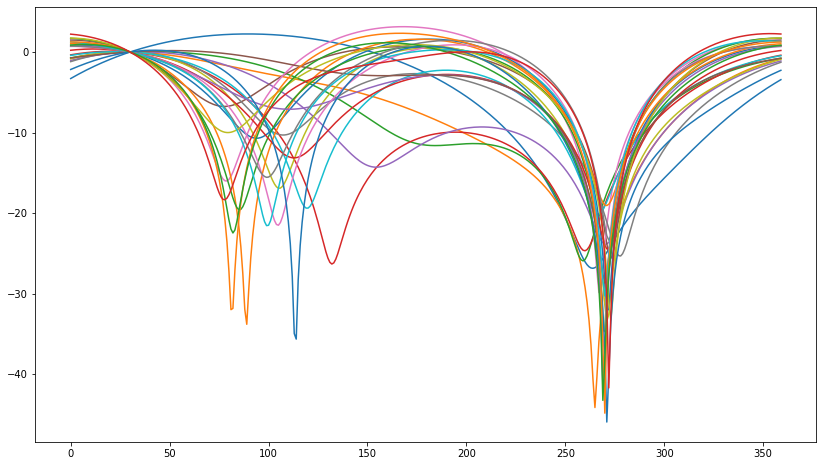

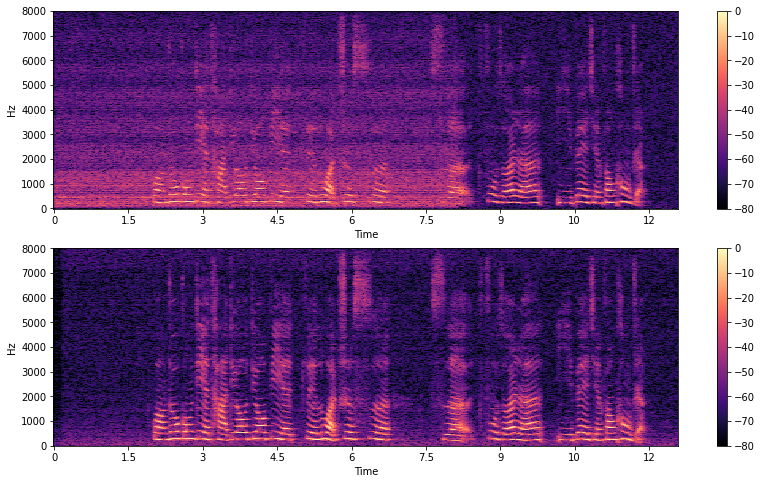

In [17]:
Rvv = np.zeros((half_bin,M,M), dtype=complex)
Ryy = np.zeros((M,M, half_bin), dtype=complex)
Rxx = np.zeros((M,M, half_bin), dtype=complex)
xi = np.zeros((frame_num, half_bin))
Rvv1 = np.zeros((frame_num, half_bin))
Yout = np.zeros((half_bin, frame_num), dtype=complex)


steer_vector = mic_array.steering_vector(look_direction=look_direction)
print(steer_vector[:,0])


init_frame = 10
for n  in range(init_frame):
    y = D[:, n, :] # [freq, channel]
    psd_yy = np.einsum('ij,il->ijl', y, y.conj()) # [freq, M,M]
    if n == 0:
        print(psd_yy.shape)
    Rvv = Rvv + psd_yy

Rvv = Rvv/init_frame
Rvv_inv = np.linalg.inv(Rvv)

w = np.zeros((M,half_bin),dtype=complex)
w_n = np.zeros((M, half_bin),dtype=complex)
for k in range(half_bin):
    w[:, k:k+1] = Rvv_inv[k] @ steer_vector[:, k:k+1]/(steer_vector[:, k:k+1].conj().T@Rvv_inv[k]@steer_vector[:, k:k+1])

beamformer_obj = beamformer(mic=mic_array, frame_len=512)
beamout = beamformer_obj.compute_beampattern(mic_array, weights=w)
tau = compute_tau(mic_array, np.array([30 * np.pi / 180, 0]))
print(tau)
mesh(beamout[:, 2:-2].T)

plt.figure(figsize=(14, 8))
plt.plot(beamout[:, 8:32])
plt.show()
# plt.plot(beamout[:, 30:33])

u = np.zeros((M,1))
u[0,0] = 1
alpha_yy = 0.85
for n in range(frame_num):
    y = D[:, n, :] # [F,M]
    for k in range(half_bin):
        Yout[k, n] = w[:, k:k+1].conj().T@y[k, :].T

yout = transform.istft(Yout)
audiowrite('output_mvdr.wav', yout)
visual(array_data[0], yout)

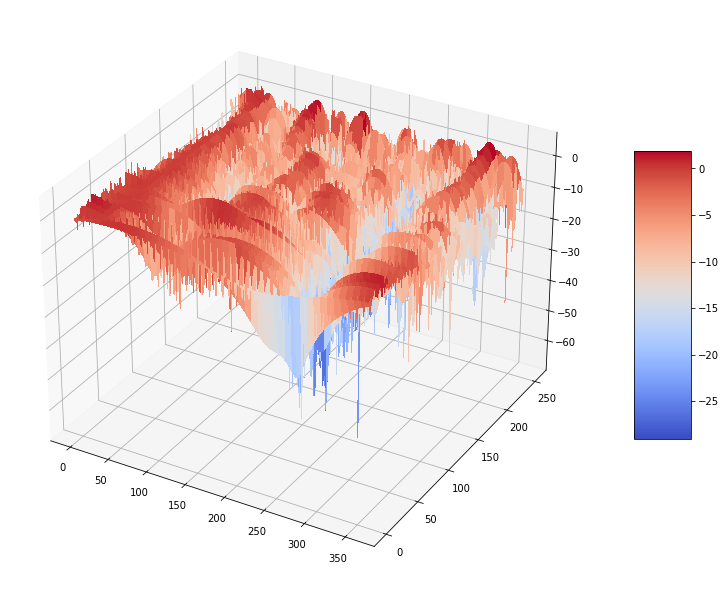

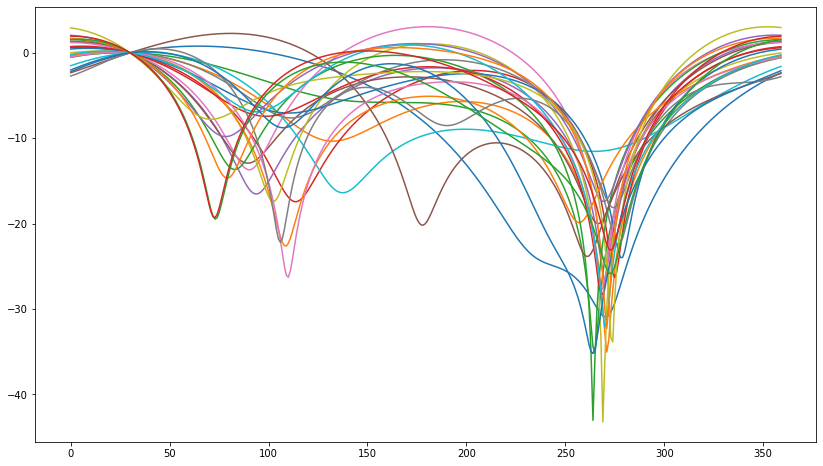

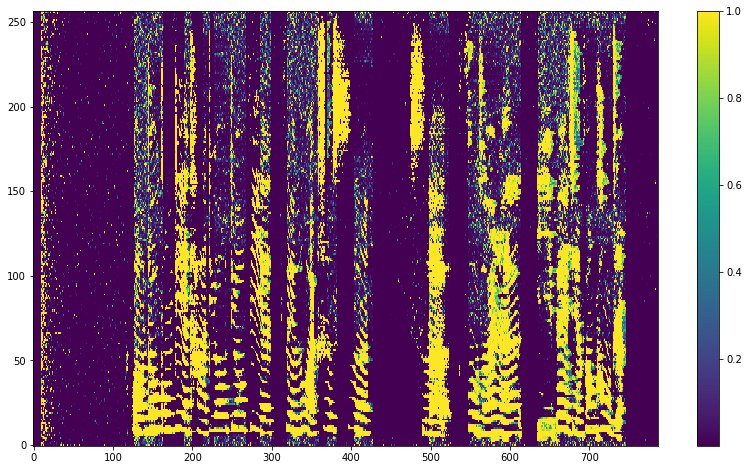

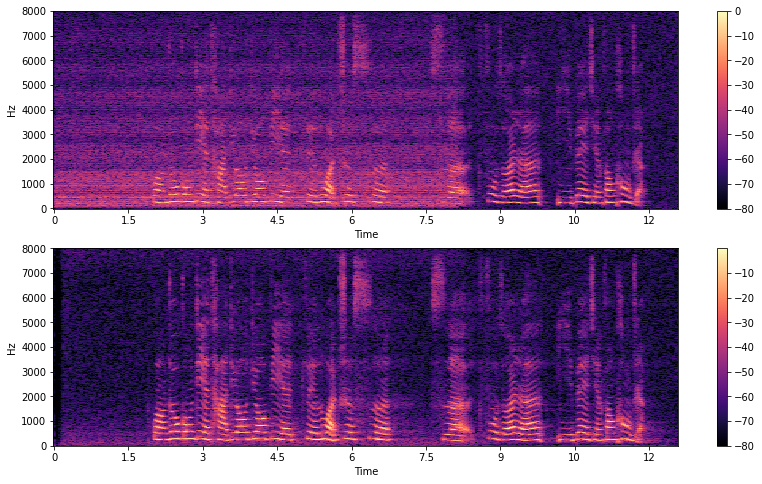

In [18]:
Rvv = np.zeros((half_bin,M,M), dtype=complex)
Ryy = np.zeros((half_bin,M,M), dtype=complex)
Rxx = np.zeros((half_bin,M,M), dtype=complex)
xi = np.zeros((frame_num, half_bin))
Rvv1 = np.zeros((frame_num, half_bin))
Rvv_inv = np.zeros((half_bin,M,M), dtype=complex)

p = np.zeros((half_bin, frame_num, ))

# online tdoa-based MVDR beamforming
channel = M
noise_estimator = McSpp(nfft=512, channels=channel, mic_array=mic_array)
noise_estimator.steer_vector = steer_vector
noise_estimator.mcra.L = 15

alpha_yy = 0.85
alpha_vv = 0.92

diag = np.eye(M) * 1e-6
diag_bin = np.broadcast_to(diag, (half_bin, M, M))

for n in range(frame_num):
    y = D[:, n, :] # [F,M]

    # psd_yy = np.einsum('ij,il->ijl', y, y.conj()) # [freq, M,M]
    # Ryy = alpha_yy * Ryy + (1-alpha_yy) * psd_yy
    # Ryy_inv = np.linalg.inv(Ryy + diag_bin)

    noise_estimator.estimation(y)
    p[:, n] = noise_estimator.p
    for k in range(half_bin):

        w[:, k:k+1] = noise_estimator.compute_weight_from_steer_vector(None, None, noise_estimator.Phi_vv_inv[k], k)
        # w[:, k:k+1] = noise_estimator.compute_weight_from_steer_vector(None, None, Ryy_inv[k], k) # bad result

        if n == 180:
            w_n[:, k:k+1] = w[:, k:k+1]
        Yout[k, n] = w[:, k:k+1].conj().T@y[k, :].T


beamformer_obj = beamformer(mic=mic_array, frame_len=512)
beamout = beamformer_obj.compute_beampattern(mic_array, weights=w_n)

mesh(beamout[:, 2:-2].T)

plt.figure(figsize=(14, 8))
plt.plot(beamout[:, 8:32])
plt.show()

pmesh(p)

yout = transform.istft(Yout)
audiowrite('output_mvdr_online.wav', yout)
visual(array_data[0], yout)